In [12]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn import metrics,model_selection,linear_model
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [13]:
def transform(x):
    if x=='Unknown':
        return 'Utterance level'
    else:
        return x
    
def assign_tone(row):
    if row['backchannels'] > 0 or row['code-switching for communicative purposes'] > 0 or row['collaborative finishes'] > 0:
        return 'Informal'
    elif row['subordinate clauses'] > 0 or row['impersonal subject + non-factive verb + NP'] > 0:
        return 'Formal'
    else:
        return 'Neutral'  # Default to Neutral if none of the criteria match
    
    
def get_new_labels(counts_df,new_column='P-V',old_column=['topic extension with the same content',
                                                          'topic extension under the previous direction']):
    cc_dd=counts_df[old_column].astype(int).values
    cc_dd=['-'.join([str(j) for j in i]) for i in cc_dd]
    counts_df[new_column]=cc_dd
    return counts_df

def get_result(test_y,test_pred):
    acc=metrics.accuracy_score(test_y,test_pred)
    pre=metrics.precision_score(test_y,test_pred,average='weighted')
    rec=metrics.recall_score(test_y,test_pred,average='weighted')
    f1s=metrics.f1_score(test_y,test_pred,average='weighted')
    return [acc,pre,rec,f1s]

def get_result_2(test_y,test_pred):
    mae=metrics.mean_absolute_error(test_y,test_pred)
    mse=metrics.mean_squared_error(test_y,test_pred)
    mape=metrics.mean_absolute_percentage_error(test_y,test_pred)
    r2=metrics.r2_score(test_y,test_pred)
    return [mae,mse,mape,r2]

# Task1

In [14]:
#读取数据
data_1=pd.read_csv('./annotations(1).csv')
data_2=pd.read_csv('./annotations(2).csv')
data_3=pd.read_csv('./annotations(3).csv')
data_4=pd.read_csv('./annotations(4).csv')
data_5=pd.read_csv('./annotations(5).csv')
data=data_1.append(data_2).append(data_3).append(data_4).append(data_5)
data['LabelLevel']=data['LabelLevel'].apply(transform)
data.index=range(len(data))


#统计频次
counts_df=pd.DataFrame({})
for i in range(0,len(data),10):
    dd=data[i:i+10]
    dd_count=pd.DataFrame(dd['Label'].value_counts()).T
    dd_count.index=[i]
    counts_df=pd.concat([counts_df,dd_count],axis=0)
    
#删除无效的数据
del counts_df['conversation closing']
del counts_df['conversation opening']

#填充缺失值
counts_df=counts_df.fillna(0)

#生成标签
counts_df['label']=counts_df.T.apply(assign_tone)

#处理顺序
columns_1=list(set(data[data['LabelLevel']!='Dialogue level']['Label']))
columns_2=[i for i in counts_df.columns if i not in columns_1]
counts_df=counts_df[columns_1+columns_2]

#保存数据
counts_df.to_csv('./feature_label.csv',encoding='utf_8_sig')

#标签合并
counts_df=get_new_labels(counts_df,new_column='P-V',old_column=['topic extension with the same content',
                                                          'topic extension under the previous direction'])
counts_df=get_new_labels(counts_df,new_column='Q-R',old_column=['overall tone choice: very formal',
                                                          'overall tone choice: quite formal and some expressions are not that formal'])
counts_df=get_new_labels(counts_df,new_column='U-Y',old_column=['overall tone choice: very informal',
                                                          'overall tone choice: quite informal, but some expressions are still formal'])
counts_df=get_new_labels(counts_df,new_column='S',old_column=['topic extension with clear new context'])
counts_df=get_new_labels(counts_df,new_column='T',old_column=['overall tone choice: relatively not formal, most expressions are quite informal'])
counts_df=get_new_labels(counts_df,new_column='W',old_column=['repeat and no topic extension'])
counts_df=get_new_labels(counts_df,new_column='X',old_column=['no topic extension and stop the topic at this point'])
counts_df['Z']=counts_df['label']
# counts_df=get_new_labels(counts_df,new_column='Z',old_column=['label'])
counts_df.to_csv('./creat_new_labels.csv',encoding='utf_8_sig')


feature=counts_df[counts_df.columns[:14]]#特征
labels=counts_df[counts_df.columns[-8:]]#标签

#打乱顺序
index_list=list(feature.index)
np.random.shuffle(index_list)

feature=feature.loc[index_list]
labels=labels.loc[index_list]

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


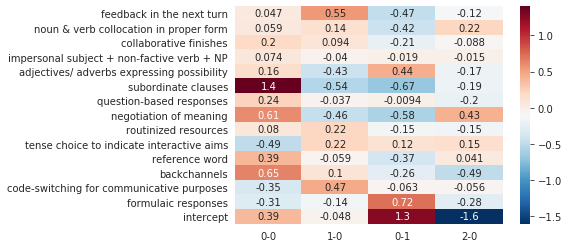

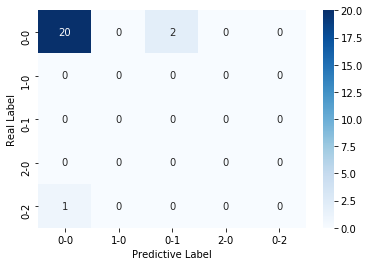

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


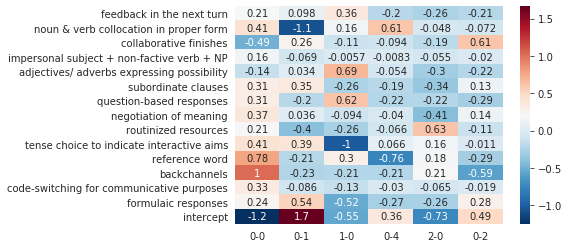

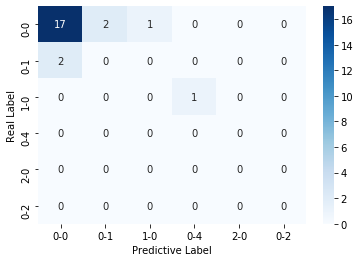

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


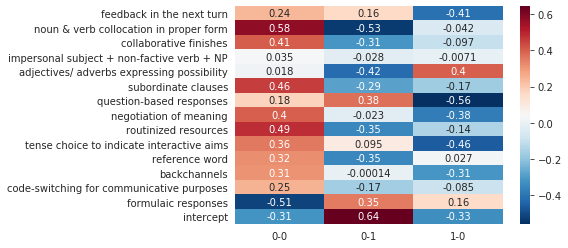

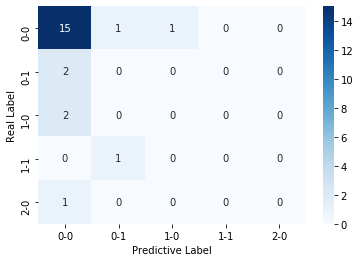

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


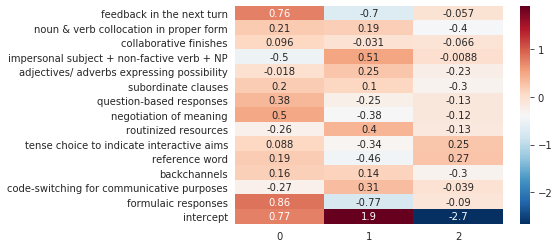

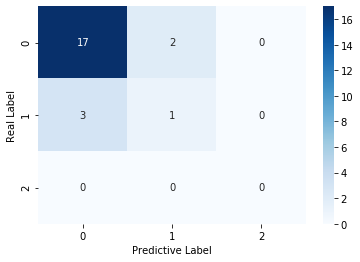

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


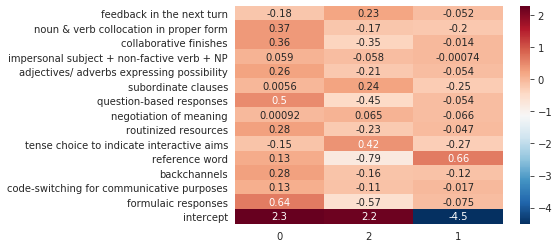

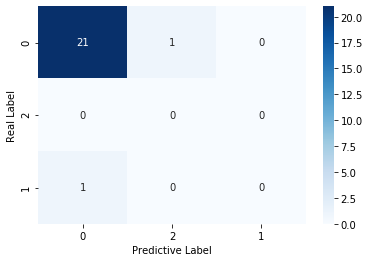

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


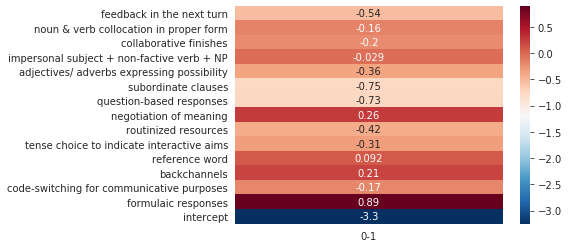

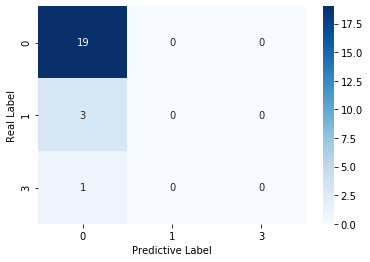

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


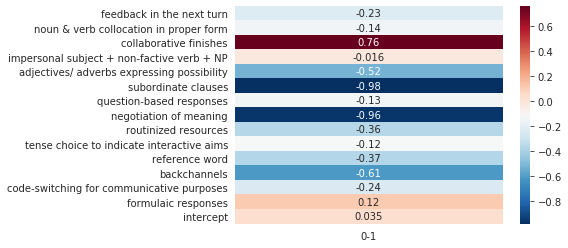

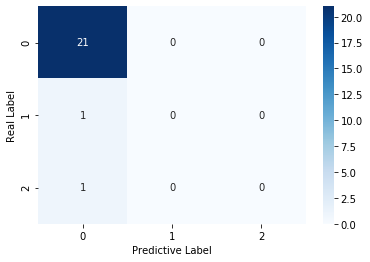

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


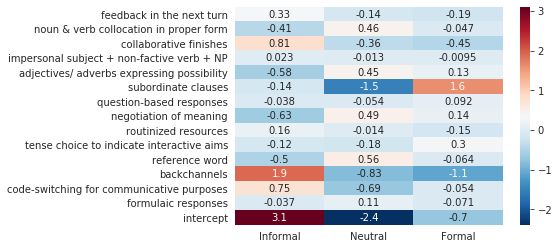

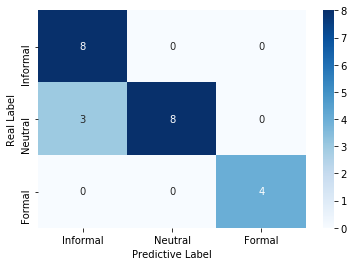

In [15]:
result_dict={}
for label_name in labels.columns[:]:
    label=labels[[label_name]]
    labels_counts=label[label_name].value_counts()#标签计数
    label_list=list(labels_counts.index)#标签列表
    label=pd.DataFrame([label_list.index(i) for i in label[label_name]],columns=[label_name])#替换标签
    labels_num=len(label_list)#类别数量
    
    train_x,test_x,train_y,test_y=model_selection.train_test_split(feature,label,train_size=0.8,shuffle=False)#数据集划分
    
    #训练模型
    model=linear_model.LogisticRegression()
    model.fit(train_x,train_y)
    #预测结果
    train_pred=model.predict(train_x)
    test_pred=model.predict(test_x)
    #评估模型
    result_dict[label_name]=get_result(test_y,test_pred)

    #训练集有的标签
    train_label_list=list(set(train_y[label_name]))
    train_label_list=sorted(train_label_list)
    train_label_list=[label_list[i] for i in train_label_list]
    
    if len(train_label_list)<3:
        train_label_list=['-'.join(train_label_list)]

    #整理权重和偏置
    coef_array=model.coef_#权重向量
    intercept_array=model.intercept_#偏置
    coef_intercept_array=np.concatenate([coef_array,intercept_array.reshape([-1,1])],1)#权重和偏置合并
    coef_intercept_df=pd.DataFrame(coef_intercept_array,index=train_label_list,columns=list(train_x.columns)+['intercept']).T
    coef_intercept_df.to_csv(f'./task-1-{label_name}-权重偏置.csv',encoding='utf_8_sig')
    
    #权重热力图
    with sns.axes_style("white"):
        sns.heatmap(coef_intercept_df,vmax=coef_intercept_df.max().max(),
                    vmin=coef_intercept_df.min().min(), annot=True,cmap="RdBu_r")
    plt.savefig(f'./task-1-{label_name}-权重热力图.png',dpi=400)
    plt.show()
    
    #混淆矩阵热力图
    cm=metrics.confusion_matrix(test_y,test_pred,labels=range(len(label_list)))
    cm=pd.DataFrame(cm,index=label_list,columns=label_list)
    cm.to_csv(f'./task-1-{label_name}-混淆矩阵.csv',encoding='utf_8_sig')
    sns.heatmap(cm, annot=True,cmap="Blues")
    plt.xlabel('Predictive Label')
    plt.ylabel('Real Label')
    plt.savefig(f'./task-1-{label_name}-混淆矩阵热力图.png',dpi=400)
    plt.show()
    
result_dict_df=pd.DataFrame(result_dict,index=['acc','pre','rec','f1s'])
result_dict_df.to_csv('./Task-1-result_df.csv',encoding='utf_8_sig')

# Task2

In [16]:
counts_df=pd.read_csv('./feature_label.csv',encoding='utf_8_sig',index_col=0)
feature=counts_df[counts_df.columns[:14]]
labels=counts_df[counts_df.columns[14:-1]].astype(int).astype(str)

#打乱顺序
index_list=list(feature.index)
np.random.shuffle(index_list)

feature=feature.loc[index_list]
labels=labels.loc[index_list]

#得到两类标签
topic_columns=[i for i in labels.columns if 'topic' in i]
choice_columns=[i for i in labels.columns if 'choice' in i]

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


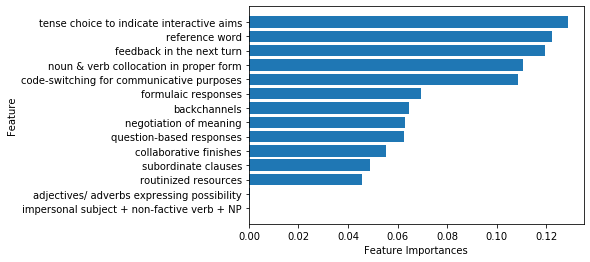

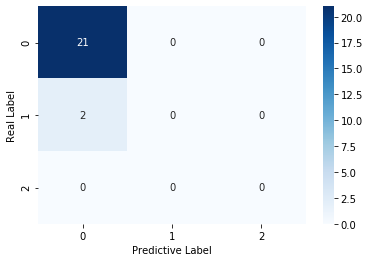

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


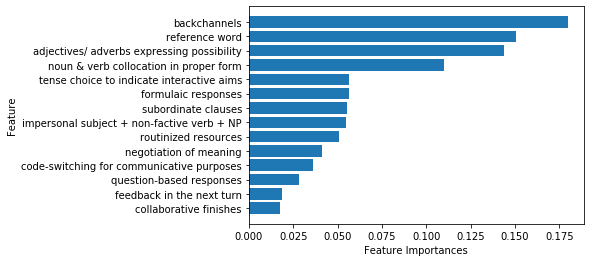

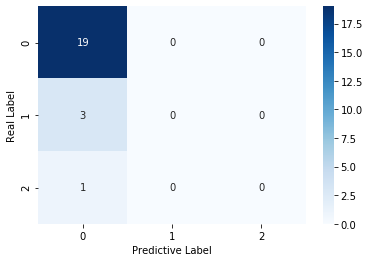

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


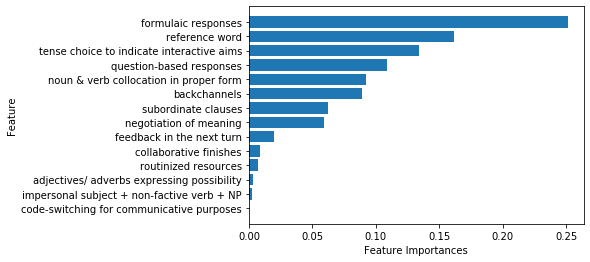

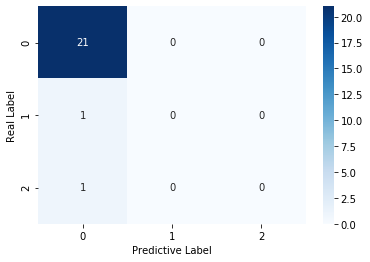

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


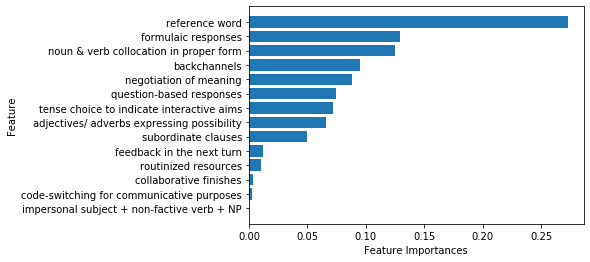

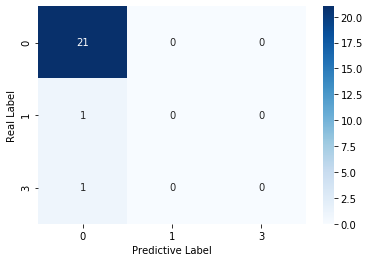

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


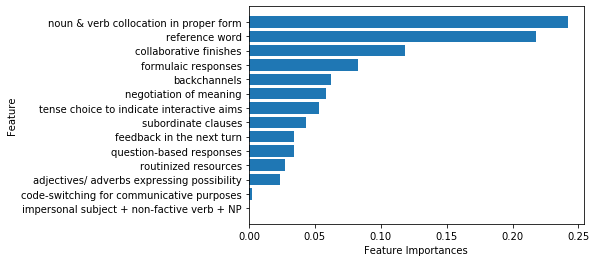

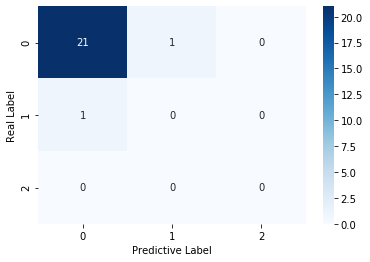

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


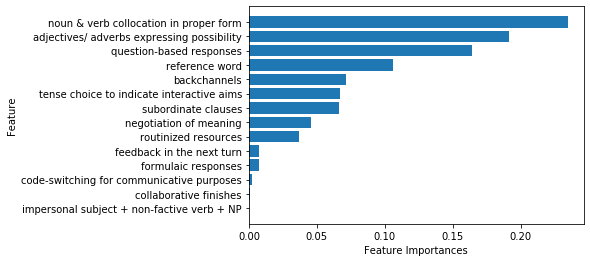

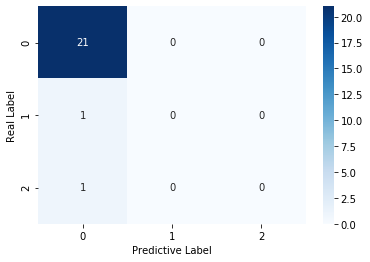

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


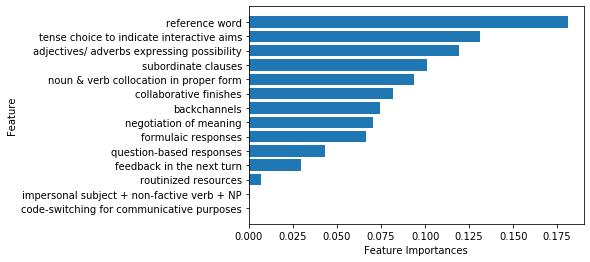

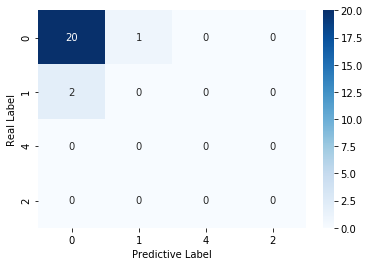

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


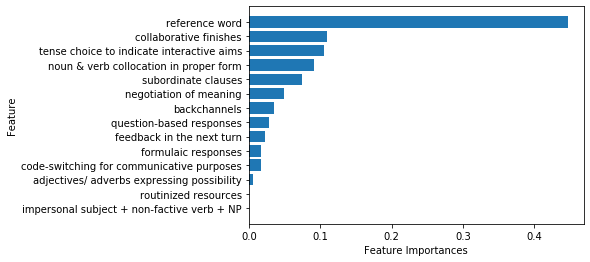

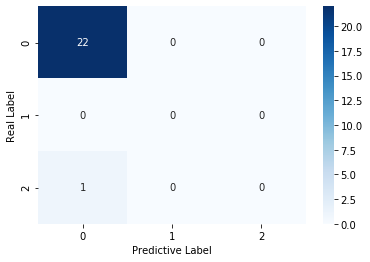

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


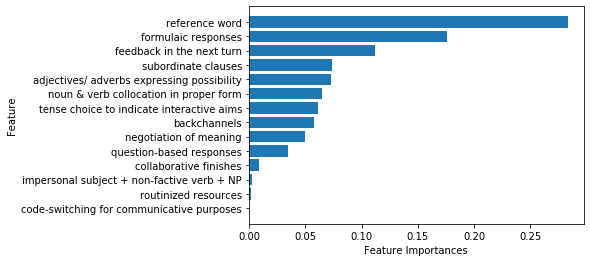

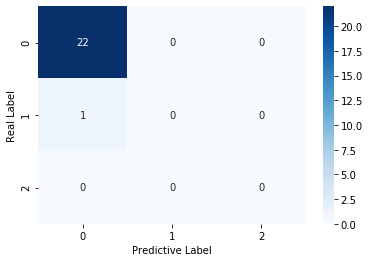

/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/gaowei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


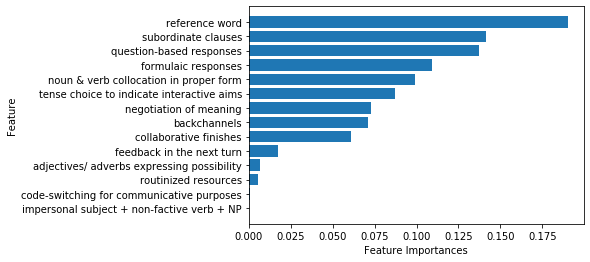

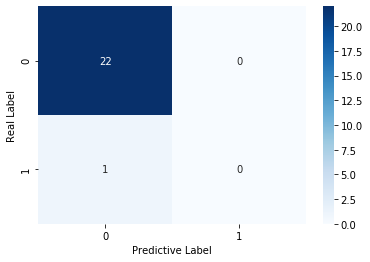

topic_acc=0.9565217391304348,choice_acc=1.0


In [17]:
result_dict={}
predict_dict,true_dict={},{}
for label_name in topic_columns+choice_columns:
    label=labels[[label_name]]
    labels_counts=label[label_name].value_counts()#标签计数
    label_list=list(labels_counts.index)#标签列表
    label=pd.DataFrame([label_list.index(i) for i in label[label_name]],columns=[label_name])#替换标签
    labels_num=len(label_list)#类别数量
    
    train_x,test_x,train_y,test_y=model_selection.train_test_split(feature,label,train_size=0.8,shuffle=False)#数据集划分
    
    model=RandomForestClassifier()
    model.fit(train_x,train_y)
    #预测结果
    train_pred=model.predict(train_x)
    test_pred=model.predict(test_x)
    #评估模型
    result_dict[label_name]=get_result(test_y,test_pred)
    
    #训练集有的标签
    train_label_list=list(set(train_y[label_name]))
    train_label_list=sorted(train_label_list)
    train_label_list=[label_list[i] for i in train_label_list]
    
    if len(train_label_list)<3:
        train_label_list=['-'.join(train_label_list)]
            
    #特征权重
    feature_importances_df=pd.DataFrame(model.feature_importances_,index=train_x.columns,columns=[label_name])
    feature_importances_df=feature_importances_df.sort_values(by=feature_importances_df.columns[0],ascending=True)
    feature_importances_df.to_csv(f'./tast-2-{label_name}-特征重要度.csv',encoding='utf_8_sig')
    
    plt.barh(feature_importances_df.index,feature_importances_df.values[:,0])
    plt.xlabel('Feature Importances')
    plt.ylabel('Feature')
    plt.savefig(f'./tast-2-{label_name}-特征重要度条形图.png',dpi=400)
    plt.show()
    
    #混淆矩阵热力图
    cm=metrics.confusion_matrix(test_y,test_pred,labels=range(len(label_list)))
    cm=pd.DataFrame(cm,index=label_list,columns=label_list)
    cm.to_csv(f'./task-2-{label_name}-混淆矩阵.csv',encoding='utf_8_sig')
    sns.heatmap(cm, annot=True,cmap="Blues")
    plt.xlabel('Predictive Label')
    plt.ylabel('Real Label')
    plt.savefig(f'./task-2-{label_name}-混淆矩阵热力图.png',dpi=400)
    plt.show()
    
    #搜集预测结果
    predict_dict[label_name]=test_pred
    true_dict[label_name]=test_y.values[:,0]
    
#整理所有的预测结果
predict_dict_df=pd.DataFrame(predict_dict,index=test_y.index)
true_dict_df=pd.DataFrame(true_dict,index=test_y.index)
predict_dict_df.to_csv('./task-2-预测结果.csv',encoding='utf_8_sig')
true_dict_df.to_csv('./task-2-真实结果.csv',encoding='utf_8_sig')
all_pred=predict_dict_df==true_dict_df#结果判断

#计数判断
topic_acc=(all_pred[topic_columns].sum(1)>2).sum()/len(all_pred)
choice_acc=(all_pred[choice_columns].sum(1)>2).sum()/len(all_pred)
print('topic_acc={},choice_acc={}'.format(topic_acc,choice_acc))

result_dict_df=pd.DataFrame(result_dict,index=['acc','pre','rec','f1s'])
result_dict_df.to_csv('./Task-2-result_df.csv',encoding='utf_8_sig')

# Task3

In [9]:
counts_df=pd.read_csv('./feature_label.csv',encoding='utf_8_sig',index_col=0)
feature=counts_df[counts_df.columns[:14]]
labels=counts_df[counts_df.columns[14:-1]].astype(int).astype(str)

#打乱顺序
index_list=list(feature.index)
np.random.shuffle(index_list)

feature=feature.loc[index_list]
labels=labels.loc[index_list]

#得到两类标签
topic_columns=[i for i in labels.columns if 'topic' in i]
choice_columns=[i for i in labels.columns if 'choice' in i]

score_df=labels.copy().astype(int)
score_df['topic extension with the same content']=score_df['topic extension with the same content']*3
score_df['topic extension with clear new context']=score_df['topic extension with clear new context']*5
score_df['topic extension under the previous direction']=score_df['topic extension under the previous direction']*4
score_df['repeat and no topic extension']=score_df['repeat and no topic extension']*2
score_df['no topic extension and stop the topic at this point']=score_df['no topic extension and stop the topic at this point']*1

score_df['overall tone choice: relatively not formal, most expressions are quite informal']=score_df['overall tone choice: relatively not formal, most expressions are quite informal']*3
score_df['overall tone choice: very formal']=score_df['overall tone choice: very formal']*5
score_df['overall tone choice: quite informal, but some expressions are still formal']=score_df['overall tone choice: quite informal, but some expressions are still formal']*4
score_df['overall tone choice: quite formal and some expressions are not that formal']=score_df['overall tone choice: quite formal and some expressions are not that formal']*2
score_df['overall tone choice: very informal']=score_df['overall tone choice: very informal']*1


labels['topic_sum']=score_df[topic_columns].sum(1)
labels['choice_sum']=score_df[choice_columns].sum(1)
labels['all_sum']=labels['topic_sum']+labels['choice_sum']
labels=labels[labels.columns[-3:]]

labels=labels/labels.max()*5#缩放
labels=round(labels,3)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


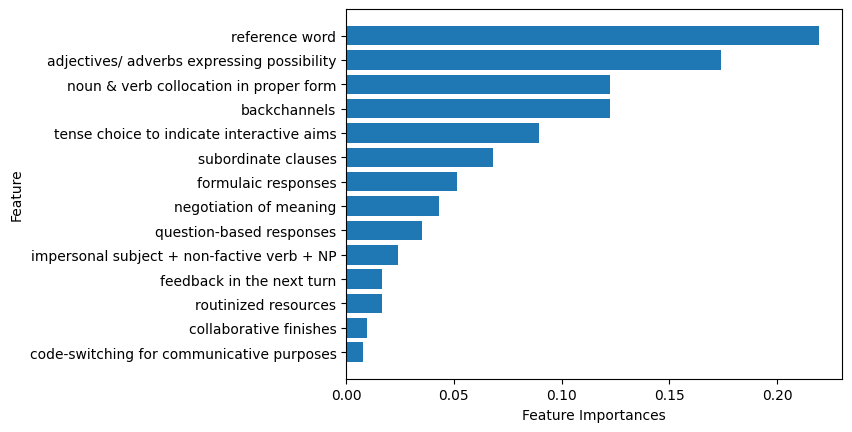

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


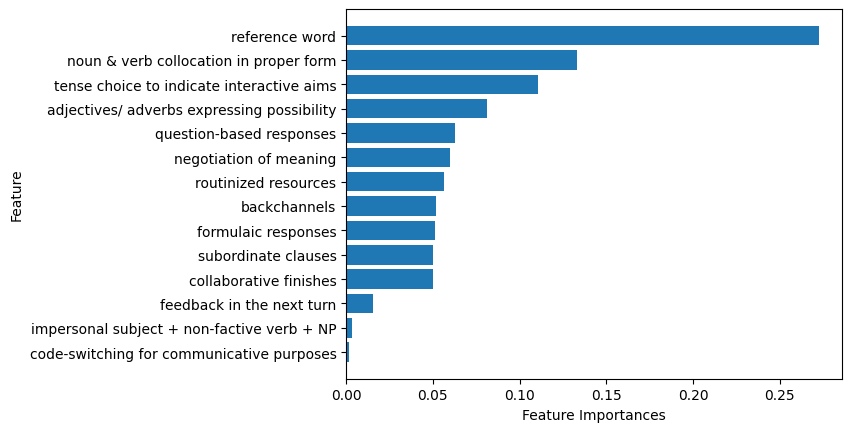

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


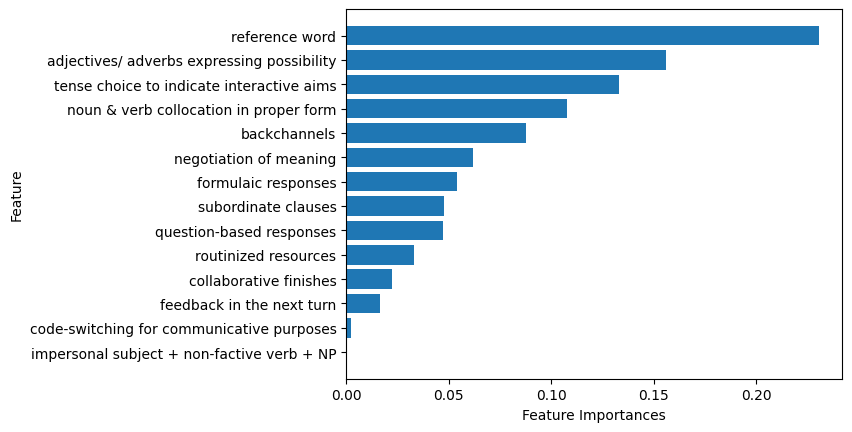

In [8]:
result_dict={}
predict_dict,true_dict={},{}
for label_name in labels.columns:
    label=labels[[label_name]]
    train_x,test_x,train_y,test_y=model_selection.train_test_split(feature,label,train_size=0.8,shuffle=False)#数据集划分
    
    model=RandomForestRegressor()
    model.fit(train_x,train_y)
    #预测结果
    train_pred=model.predict(train_x)
    test_pred=model.predict(test_x)
    #评估模型
    result_dict[label_name]=get_result_2(test_y,test_pred)
    
    #特征权重
    feature_importances_df=pd.DataFrame(model.feature_importances_,index=train_x.columns,columns=[label_name])
    feature_importances_df=feature_importances_df.sort_values(by=feature_importances_df.columns[0],ascending=True)
    feature_importances_df.to_csv(f'./tast-3-{label_name}-特征重要度.csv',encoding='utf_8_sig')
    
    plt.barh(feature_importances_df.index,feature_importances_df.values[:,0])
    plt.xlabel('Feature Importances')
    plt.ylabel('Feature')
    plt.savefig(f'./tast-3-{label_name}-特征重要度条形图.png',dpi=400)
    plt.show()
    
    #搜集预测结果
    predict_dict[label_name]=test_pred
    true_dict[label_name]=test_y.values[:,0]
    
#整理所有的预测结果
predict_dict_df=pd.DataFrame(predict_dict,index=test_y.index)
true_dict_df=pd.DataFrame(true_dict,index=test_y.index)
predict_dict_df.to_csv('./task-3-预测结果.csv',encoding='utf_8_sig')
true_dict_df.to_csv('./task-3-真实结果.csv',encoding='utf_8_sig')


result_dict_df=pd.DataFrame(result_dict,index=['mae','mse','mape','r2'])
result_dict_df.to_csv('./Task-3-result_df.csv',encoding='utf_8_sig')